# GradientBoosting

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, roc_curve, mean_squared_error


In [4]:
df = pd.read_pickle('datenVorbOversampling.pkl')

In [3]:
df

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,Geschlecht,Alter,Interesse
0,1,27.052895,0,1,1,30821.907934,26.000000,84,0,52,1.0
1,1,14.548246,0,0,1,32108.634503,137.147173,23,1,27,1.0
2,1,28.000000,0,0,1,35592.000000,124.000000,45,1,28,1.0
3,1,12.729017,0,1,1,88364.182254,41.758275,234,0,51,1.0
4,1,15.000000,0,0,0,2630.000000,152.000000,199,0,23,0.0
...,...,...,...,...,...,...,...,...,...,...,...
535033,1,41.000000,0,1,1,24499.785274,127.340497,217,0,40,1.0
535034,1,31.667769,0,1,1,22430.355062,124.000000,99,0,28,1.0
535035,1,28.000000,0,1,1,26446.000000,26.000000,188,0,53,0.0
535036,1,9.000000,0,0,1,35835.000000,152.000000,59,1,22,0.0


## Modell Training

In [4]:
X = df.drop('Interesse', axis=1)
y = df['Interesse']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=1400, learning_rate=0.2, max_depth=3) 
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.2, n_estimators=1400)

## Cross Validation und Test 

In [5]:
scores = cross_val_score(gb_model, X_train, y_train, cv=5)

print(f'Trainingsatz Cossval: {scores}')
print(f'Druchschnitt:  {scores.mean()}')

Trainingsatz Cossval: [0.89644354 0.89646886 0.89497363 0.89467993 0.8961084 ]
Druchschnitt:  0.8957348736571855


In [6]:
y_pred = gb_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(f"Train Accuracy: {gb_model.score(X_train, y_train):.4f}")

Accuracy: 0.8969547448165869
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     80409
         1.0       0.91      0.88      0.90     80103

    accuracy                           0.90    160512
   macro avg       0.90      0.90      0.90    160512
weighted avg       0.90      0.90      0.90    160512

Train Accuracy: 0.9017


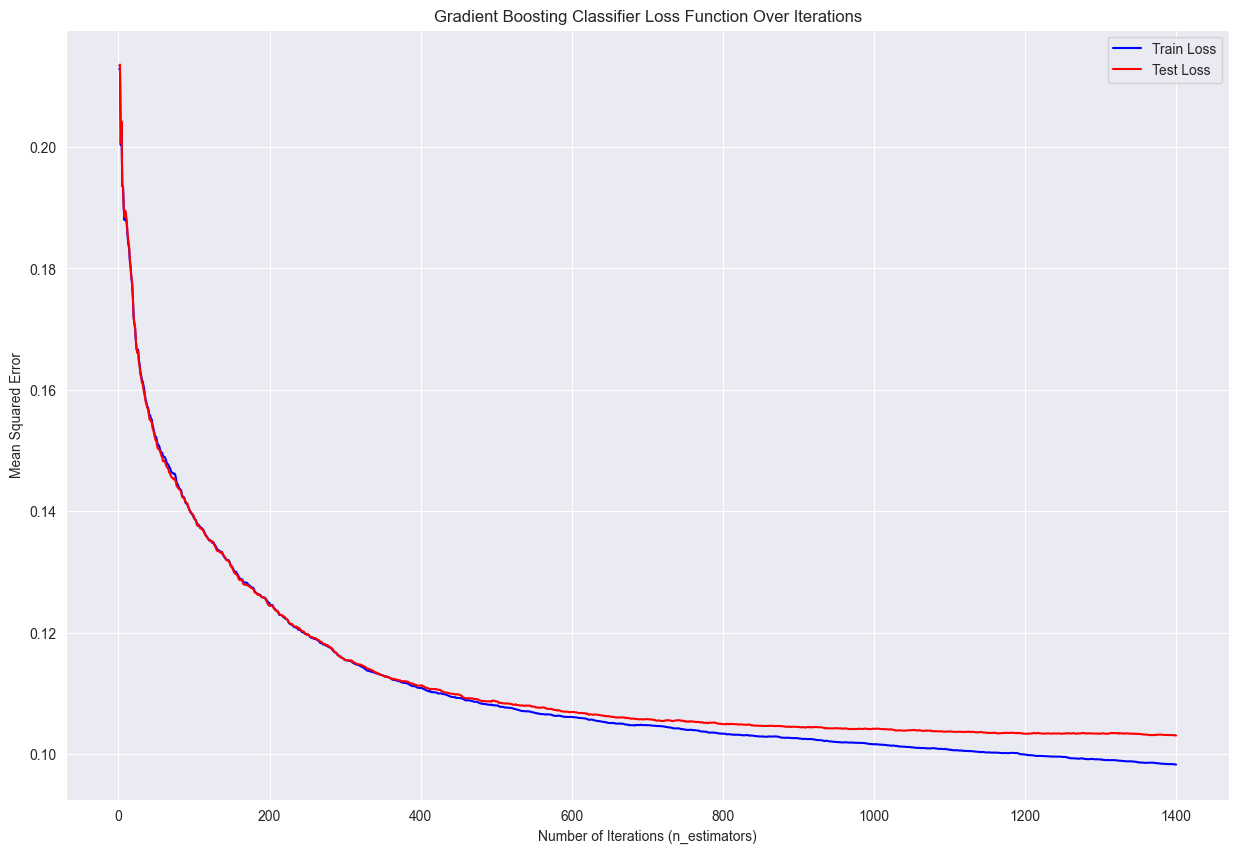

In [7]:
# Train loss überwachen 
train_loss = []
for y_pred in gb_model.staged_predict(X_train):
    loss = mean_squared_error(y_train, y_pred)
    train_loss.append(loss)

# Test loss überwachen 
test_loss = []
for y_pred in gb_model.staged_predict(X_test):
    loss = mean_squared_error(y_test, y_pred)
    test_loss.append(loss)

# loss über die Iterationen plotten
plt.figure(figsize=(15, 10))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, len(test_loss) + 1), test_loss, label="Test Loss", color='red')
plt.title("Gradient Boosting Classifier Loss Function Over Iterations")
plt.xlabel("Number of Iterations (n_estimators)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()


## Auswertungen

Log Loss: 0.2094
AUC: 0.9712


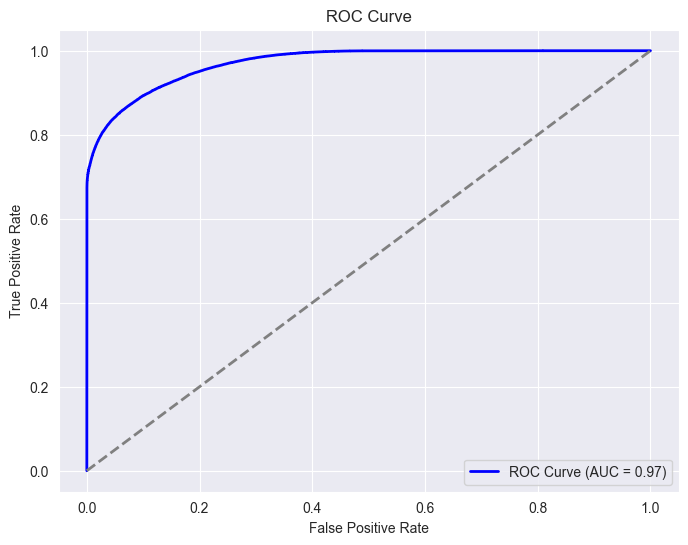

In [10]:
# Vorhersagewahrscheinlichkeiten für die Klasse 1 (positive Klasse)
y_pred_prob = gb_model.predict_proba(X_test)[:, 1]
# Log Loss
logloss = log_loss(y_test, y_pred_prob)

# AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Log Loss: {logloss:.4f}")
print(f"AUC: {auc:.4f}")

# Berechnung der FPR und TPR für verschiedene Schwellenwerte
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)


# Plotten der ROC-Kurve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonale Linie für zufällige Klassifikation
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Feature Einfluss

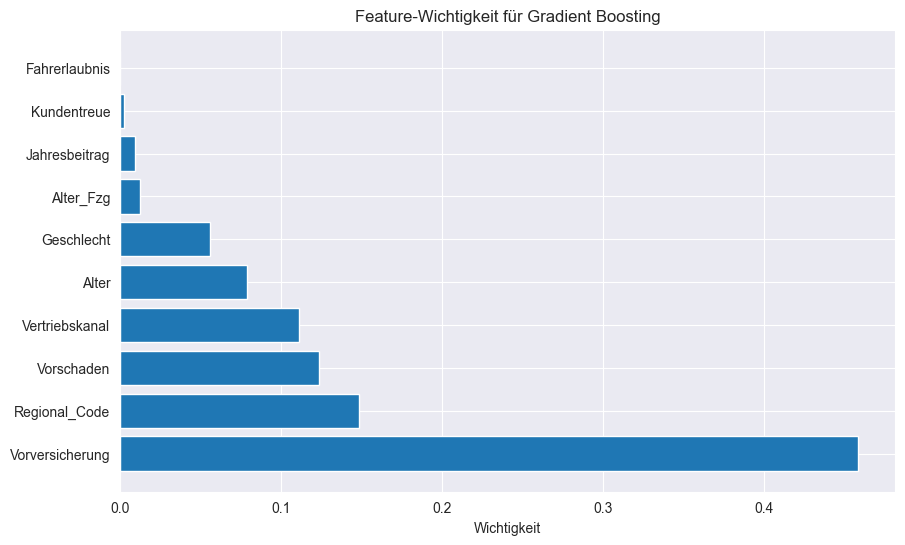

In [9]:
# Feature-Wichtigkeiten extrahieren
feature_importances = gb_model.feature_importances_

# Feature-Wichtigkeiten sortieren und anzeigen
indices = np.argsort(feature_importances)[::-1]

# Plot der Feature-Wichtigkeiten
plt.figure(figsize=(10, 6))
plt.title("Feature-Wichtigkeit für Gradient Boosting")
plt.barh(range(X.shape[1]), feature_importances[indices], align="center")
plt.yticks(range(X.shape[1]), [X.columns[i] for i in indices])
plt.xlabel("Wichtigkeit")
plt.show()


## Weiters Vorgehen: 

### Fehler gewichtung einstellen, um den Recall auf 1 zu verbessern könnten Fehler auf klasse eins schwerer gewichtet werden als fehler auf klasse 0
### ebenso könnte das einstellen des Thresholds den Recall auf 1 verbessern
 
### um grundlegende Verbessereungen zu erreichen könnte weitere Zeit in das Feature Engeneering gesteckt werden
### bei fast 90% Accuracy und der einer AUC von 0,97 ist das model allerdings schon in der Lage sehr gute entscheidungen zu Treffen
### es Sollte aufjeden Fall noch zeit in das Hyperparameter Tuning gesteckt werden, da hier mit den vorhanden Features noch nicht das volle Potential ausgeschöpft ist 